In [2]:
import json
from pathlib import Path
from PIL import Image as PILImage

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm


from rhana.labeler.unet import RHEEDTensorImage, RHEEDTensorMask, rle_encode, rle_decode
from rhana.labeler.masker import UnetMasker
from rhana.io.kashiwa import find_raw_rheed
from rhana.pattern import Rheed, RheedMask
from rhana.tracker.iou_tracker import IOUTracker, regions2detections, IOUMaskTracker

/var/folders/g7/5d8qpz9s6zjcs0jq8qyx0j7w0000gn/T/ipykernel_70602/1122737501.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# the rheeds here is what used to be a video
# but the whole video is too big 
# we just replaced it with only the last video frame

rheed_folder = Path("assets/LastImage")

rheed_paths = list(rheed_folder.glob("*.png"))
rheeds = {}
for rheed in rheed_paths:    
    rheeds[rheed.stem] = [rheed]

In [3]:
rheeds

{'IT009': [Path('assets/LastImage/IT009.png')],
 'IT021': [Path('assets/LastImage/IT021.png')],
 'IT020': [Path('assets/LastImage/IT020.png')],
 'IT008': [Path('assets/LastImage/IT008.png')],
 'IT022': [Path('assets/LastImage/IT022.png')],
 'IT023': [Path('assets/LastImage/IT023.png')],
 'IT027': [Path('assets/LastImage/IT027.png')],
 'IT030': [Path('assets/LastImage/IT030.png')],
 'IT024': [Path('assets/LastImage/IT024.png')],
 'IT018': [Path('assets/LastImage/IT018.png')],
 'IT025': [Path('assets/LastImage/IT025.png')],
 'IT028': [Path('assets/LastImage/IT028.png')],
 'IT014': [Path('assets/LastImage/IT014.png')],
 'IT015': [Path('assets/LastImage/IT015.png')],
 'IT029': [Path('assets/LastImage/IT029.png')],
 'IT017': [Path('assets/LastImage/IT017.png')],
 'IT016': [Path('assets/LastImage/IT016.png')],
 'IT006': [Path('assets/LastImage/IT006.png')],
 'IT012': [Path('assets/LastImage/IT012.png')],
 'IT013': [Path('assets/LastImage/IT013.png')],
 'IT007': [Path('assets/LastImage/IT007.

In [4]:
ls ../learner

UNet_1647_Apr27_2022.pkl


In [5]:
path = "../learner/UNet_1647_Apr27_2022.pkl"

In [6]:
masker = UnetMasker(path)

In [7]:
index_df = pd.DataFrame(
    columns=[
        "image_path",
        "full_mask_spot",
        "full_mask_streak",
        "crop_args",
        "crop_path",
        "crop_mask_spot",
        "crop_mask_streak"]
)

In [8]:
offset = 50 # just to discard the direct beam location
window_width = 400 # define the area of interest
window_height = 200 ## define the area of interest

In [9]:
crop_rheed_folder = rheed_folder.parent / ( rheed_folder.stem + "_cropped" )
crop_rheed_folder.mkdir(exist_ok=True)

In [1]:
from importlib import reload
import rhana
reload(rhana)
reload(rhana.labeler.unet)
reload(rhana.labeler.masker)
reload(rhana.io.kashiwa)
reload(rhana.pattern)
reload(rhana.tracker.iou_tracker)

from rhana.labeler.unet import RHEEDTensorImage, RHEEDTensorMask, rle_encode, rle_decode
from rhana.labeler.masker import UnetMasker
from rhana.io.kashiwa import find_raw_rheed
from rhana.pattern import Rheed, RheedMask
from rhana.tracker.iou_tracker import IOUTracker, regions2detections, IOUMaskTracker

# the following code is the main process pipepline
# it takes a video stream, track the direct beam, crop out the interested region and predict a mask over it

# in this demo you can look at the plot and see if each one need some correction

# set True to plot the direct beam tracking
show_intermediate = True

for IT in rheeds.keys():
# for IT in tqdm(failed, leave=False):
# for IT in tqdm(not_processed, leave=False):
# for IT in tqdm(["IT025"], leave=False):
    if len(rheeds[IT])==0: continue
    is_first = True
    lost_track = False
    
    raw_tracker = IOUMaskTracker(t_min=100000, sigma_iou=0.4)
    detail_tracker = IOUTracker(t_min=2, sigma_iou=0.4)
    
    for i, path in tqdm(enumerate(rheeds[IT]), total=len(rheeds[IT]), leave=False):
        
        # the first part track the direct beam and crop a window below it
        
        # get the mask using UNet 
        rd = Rheed.from_image(path)           

        rd = rd.mean_clip().min_max_scale()
        masks = masker.predict(rd)
        rdm_streak = RheedMask(rd, masks['streak'])
        rdm_spot = RheedMask(rd, masks['spot'])
        
        rdm_spot.get_regions(with_intensity=True)
        rdm_spot.filter_regions(min_area=10)

        # track the direct beam using IOU tracker
        region2tracks = raw_tracker.update(regions2detections(rdm_spot.regions), i)
        
        if is_first:
            # run blob detection and region detection in the same time
            # accept if all point to one region
            # pick the one with the biggest mask size if the region the blob point do not agree with the top region 
            db, db_i, track = rdm_spot.get_direct_beam(method="top+tracker", tracker=raw_tracker)
            db_r = rdm_spot.regions[db_i]
            
            rd.get_blobs()
            blob_db, blob_i= rd.get_direct_beam()
            
            blob_r, blob_ri= rdm_spot.get_region_within(x=blob_db[0], y=blob_db[1])
            if blob_ri != db_i and blob_r.area > db_r.area:
                db = blob_db
                db_i = blob_ri
                track = raw_tracker.region2track[blob_ri]
                
            is_first = False
                            
        else:
            try:
                # print("using tracking")
                db, db_i, track = rdm_spot.get_direct_beam(method="tracker", tracker=raw_tracker, track=track)
                if lost_track:
                    print("track is re-initiated by tracking")
                
                lost_track = False
            except KeyError as e:
                if not lost_track:
                    print(f"lost track at {path}")

                lost_track = True
                #
        if lost_track:            
            db_r, db_i = rdm_spot.get_region_within(*db)
            if db_r is not None:
                track = raw_tracker.region2track[db_i]
                print("track is re-initiated by locate a region that contain db point")
                lost_track = False
                
        # crop up a window that is always below the direct beam
        db = (round(db[0]), round(db[1]))

        sx = db[0] + offset
        sy = db[1] - window_width//2
        ex = db[0] + offset + window_height
        ey = db[1] + window_width//2

        cr_rdm_spot = rdm_spot.crop(sx=sx, sy=sy, ex=ex, ey=ey, inplace=False)
        cr_rdm_streak = rdm_streak.crop(sx=sx, sy=sy, ex=ex, ey=ey, inplace=False)

        # the second part would track only the croped area which would further stablize the tracking
        cr_rdm_spot.get_regions(with_intensity=True)
        cr_rdm_spot.filter_regions(min_area=10)

        # track the direct beam using IOU tracker
        region2tracks = detail_tracker.update(regions2detections(cr_rdm_spot.regions), i)
        
        # save the result
        
        # save crop image
        cr_im = PILImage.fromarray(np.uint8(cr_rdm_spot.rd.pattern*255))
        cr_path = crop_rheed_folder/IT/f"{path.stem}.png"
        cr_path.parent.mkdir(exist_ok=True)
        cr_im.save(cr_path)

        cr_masks = {"spot": cr_rdm_spot.mask, "streak": cr_rdm_streak.mask}
        
        cr_masks_rle = {k : rle_encode(v) for k, v in cr_masks.items()}
        masks_rle = {k : rle_encode(v) for k, v in masks.items()}

        cr_args = {
            "db_x":db[0],
            "db_y":db[1],
            "offset":offset,
            "window_width":window_width,
            "window_height":window_height,
            "cr_sx": sx,
            "cr_sy": sy,
            "cr_ex": ex,
            "cr_ey": ey,
        }

        record = {}
        record['image_path'] = str(path)
        record['full_mask_spot'] = masks_rle['spot']
        record['full_mask_streak'] = masks_rle['streak']
        record['crop_mask_spot'] = cr_masks_rle['spot']
        record['crop_mask_streak'] = cr_masks_rle['streak']

        record['crop_args'] = json.dumps(cr_args)
        record['crop_path'] = cr_path

        print(record)

        index_df = pd.concat([index_df, pd.DataFrame({k:[v] for k, v in record.items()})], ignore_index=True)
        
        if i % 2 == 0 and show_intermediate:
        #    rdm_spot.plot_regions()
            rdm_spot.plot_region(db_i)
            plt.show()
        

AttributeError: module 'rhana' has no attribute 'labeler'

(<Figure size 640x480 with 1 Axes>, <Axes: >)

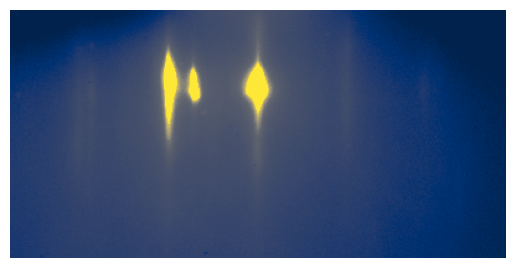

In [20]:
cr_rdm_spot.rd.plot_pattern()

In [21]:
rheed_folder

Path('assets/LastImage')

In [22]:
index_df.to_csv(crop_rheed_folder / "rheed_masks.csv", index=None)

In [23]:
# 

In [24]:
# plot the track's properties change (both raw and processed rheed)
# property: intensity, image moment?, center of gravity

# plot region with image in different time stamp
